# Installation 

from the root kmcluster folder you want to run the 'pip install -e .' then you will be able to run the box below without errors

In [16]:
import numpy as np 
from kmcluster.core.kmc import kmc
from kmcluster.core.transition_conditions import rfkmc, rkmc
from kmcluster.core.intialize import random_init, boltz, global_minimum_only, selected
from kmcluster.core.data import pull_json

# Parameters 

you can either create a dictionary manually or import a json using "pull_json" 

In [17]:
time_end = 100 # time stop condition
steps = 100 # number of steps
size = 100 # number of independet trajectories 
n_states = 10 # number of states
energies = [0, 1.0, 1.0, -1.0] # list of energies 
init_dict = {0:0.5, 1:0.5} # dictionary of custom proportions to start with ({state:proportion,...})
temp_boltz = 1.0  # temperature for boltzmann distribution + kmc
temp_sample = 1.0 # temp for sampling kmc
rates_two_states = [[0.0,0.1],[0.01, 0.0]]
rates_four_states_sink = np.array([[0.0,0.0,0.0,0.1],[0.0,0.0,0.0,0.1],[0.0,0.0,0.0,0.1],[0.0,0.0,0.0,0.0]])
rates_four_sym = np.array(
    [[0.0,10.1,0.0,0.0],
    [0.0,0.0,1.1,0.0],
    [0.0,0.0,0.0,1.1],
    [1.1,0.0,0.0,0.0]])
rates_as_sparse = []

parameters = {
    'time': time_end,
    'steps': steps,
    'size': size,
    'n_states': n_states,
    'energies': energies,
    'rates': rates_four_sym.tolist(),
    'draw_method': 'rfkmc',
    'init_method': 'random_init',
    #'draw_obj': rfkmc(rates_four_sym),
    #'init_obj': random_init(size, 4),
    't_boltz': 10, 
    'init_state_proportion': {0:0.5, 1:0.5}
}


# save parameters as json
#import json 
#json.dump(parameters, open('parameters.json', 'w'), indent=4)

# load parameters from json
parameters = pull_json('./parameters.json')

# Initializations

1) boltz - given temp, number of trajectories, and energies initialize
2) global min - give it a list of energies
3) selected - user specified in the format {index of start:proportion, ...}
4) random

In [18]:
# different initalization options 
init_boltz = boltz(energies = energies, T=temp_boltz, size = size)
init_global_min = global_minimum_only(energies=energies, size=size)
init_select = selected(size, init_dict, n_states)
init_random = random_init(size, n_states)

# Drawing Criteria: 
Two options are available right now: 
1) rfkmc - rejection free kmc 
2) rkmc - rejection kmc where you input parameter r_0

In [19]:
rfkmc_obj=rfkmc()
rkmc = rkmc(r_0 = 1.0)

# Putting it together in kmc()
You can now construct the kmc object and .run() will run the trajectories. Note that steps != time so you can either set steps or time_stop where time will stop once all trajectories reach a certain time or steps are reached, whichever comes first.

In [20]:
rfkmc_obj=rfkmc()

init_boltz = boltz(
    energies = energies, 
    T=temp_boltz, 
    size=10000)

# initialize kmc object
kmc_boltz = kmc(
    steps=1000,
    time_stop = 1000, 
    pop_size=parameters['size'],
    rates=rates_four_sym,
    draw_crit=rfkmc_obj,
    initialization=init_boltz,
)

# run calcs
kmc_boltz.run(n_steps=10)

100%|██████████| 10/10 [00:00<00:00, 16.43it/s]


In [21]:
# extract trajectories after run
trajectories = kmc_boltz.trajectories

# Visualizations 

In [22]:
from kmcluster.core.viz import (
    plot_top_n_states, 
    graph_trajectories_static, 
    graph_trajectories_dynamic, 
    communities_static, 
    compute_state_counts
)

In [23]:
#compute_state_counts(trajectories, resolution=0.1, n_states=4)

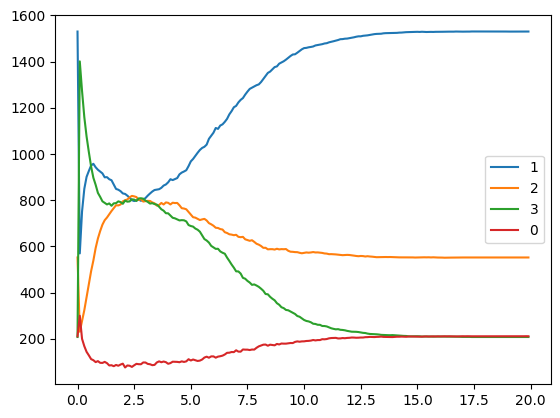

In [24]:
# trajectories object
# n_show = number of states to show
# total_states = total state number of states in the system 
# max_time = upper bound of plotting 

plot_top_n_states(
    trajectories, 
    n_show=4, 
    total_states = 4, 
    resolution = 1,
    max_time = 20)

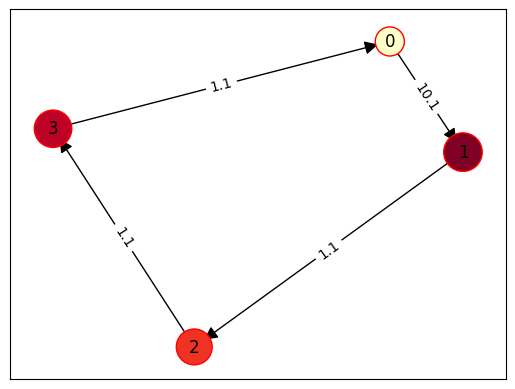

[(0, {}), (1, {}), (2, {}), (3, {})]


In [25]:
time_slice = 0
pos = graph_trajectories_static(
    trajectories=trajectories, 
    rates = rates_four_sym,
    frame=1,
    ret_pos = True
) 
# TODO: heatmap graph of a given timeframe, -1 is for the last step each traj reached

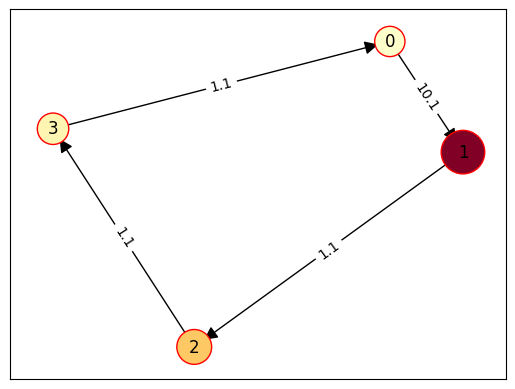

[(0, {}), (1, {}), (2, {}), (3, {})]


In [26]:
time_slice = 0
graph_trajectories_static(
    trajectories=trajectories, 
    rates = rates_four_sym,
    frame=10, 
    pos = pos
) 

In [27]:
#%matplotlib nbagg
graph_trajectories_dynamic(trajectories=trajectories, rates = rates_four_sym, time_max = 1000, n_states=4, file_name="Pt4H1") # TODO: movie of heatmap over time

TypeError: graph_trajectories_dynamic() got an unexpected keyword argument 'file_name'

In [ ]:
#communities_static(trajectories, time = 1000) # TODO: create superbasins of states using community graph algorithms

In [ ]:
#communities(trajectories, max_time = 1000) # TODO: create superbasins of states using community graph algorithms

# Real Data

In [28]:
Pt_H1_links=[[0,1,0.15],[0,2,0.61],[0,3,0.39],[2,4,0.27],[2,6,0.50],[2,8,0.66],[3,8,0.50],[5,7,0.52],[5,9,0.66],[5,6,0.66]]
H_H1_links=[[0,6,0.52],[1,2,0.28],[2,5,0.22],[3,5,0.22],[7,8,0.15],[8,9,0.14]]
Pt4H1_rawE=[-17.71720725 ,-17.68531409 ,-17.57336808 ,-17.50640668,-17.50097929,-17.50887522,-17.38155630,-17.25580137,-17.15164472,-17.13649884]
H1_E=[Pt4H1_rawE[x]-Pt4H1_rawE[0] for x in range(0,len(Pt4H1_rawE))]

In [29]:
from kmcluster.core.data import sparse_to_rate_mat

rates_mat = sparse_to_rate_mat(Pt_H1_links, len(Pt4H1_rawE))

In [30]:
rfkmc_obj=rfkmc()

init_boltz = boltz(
    energies = H1_E, 
    T=temp_boltz, 
    size=10000)

# initialize kmc object
kmc_boltz = kmc(
    steps=1000,
    time_stop = 1000, 
    pop_size=1000,
    rates=rates_mat,
    draw_crit=rfkmc_obj,
    initialization=init_boltz,
)

# run calcs
kmc_boltz.run(n_steps=1000)
trajectories = kmc_boltz.trajectories

100%|██████████| 1000/1000 [00:02<00:00, 345.14it/s]


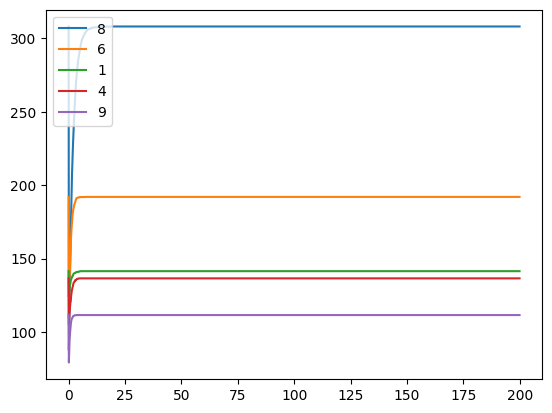

In [31]:
plot_top_n_states(
    trajectories, 
    n_show=5, 
    total_states = len(Pt4H1_rawE), 
    resolution = 1,
    max_time = 200)

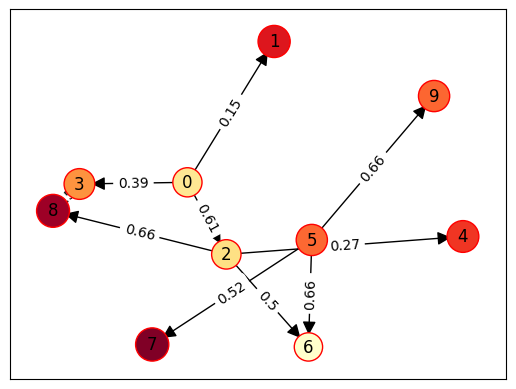

[(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (6, {}), (8, {}), (5, {}), (7, {}), (9, {})]


In [32]:
time_slice = 0
pos = graph_trajectories_static(
    trajectories=trajectories, 
    rates = rates_mat,
    frame=1,
    ret_pos = True
) 

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7f9968bc35e0> (for post_execute):


ValueError: s must be a scalar, or float array-like with the same size as x and y

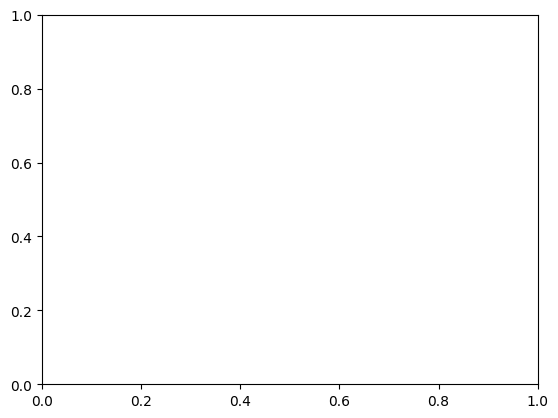

In [64]:
graph_trajectories_dynamic(
    trajectories=trajectories, 
    rates = rates_mat, 
    time_max = 100,
    ret_pos = True
    ) 
#graph_trajectories_dynamic(trajectories=trajectories, rates = rates_four_sym, time_max = 1000) # TODO: movie of heatmap over time

In [14]:
Pt4H2_rawE=[-21.98593527 ,-21.85625043  ,-21.83048650, -21.77242143 ,-21.73991713 ,-21.72890235 ,-21.69202740 ,-21.67246325 ,
            -21.66831165 , -21.66826539 ,-21.66667044 ,-21.66460538 ,-21.66208787,-21.61501272,-21.61210687 ,-21.59105142,
            -21.66060508, -21.58187910  ,-21.55195177 , -21.51766584 ,
            -21.50714264 , -21.48263554 ,-21.41078190 ,-21.38308188 ,-21.26811373,-21.59541768 ]
H2_E=[Pt4H2_rawE[x]-Pt4H2_rawE[0] for x in range(0,len(Pt4H2_rawE))]